In [1]:
import sys
import datetime
import tempfile
import re
import math
import json
from easyocr import Reader
import cv2
from PIL import Image
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

In [2]:
cv2.__version__

'4.5.4'

In [3]:
pytesseract.get_tesseract_version() 
# pytesseract.__version__

<Version('4.1.1')>

In [41]:
image_path = '../output/수입면장-PDF-img3.jpg'

x = xmin
y = ymin
w = xmax - xmin
h = ymax - ymin

cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),15)

In [42]:
image = cv2.imread(image_path)
draw_image = image.copy()
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# ret, imthres = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

In [43]:
def plt_imshow(title='image', img=None, figsize=(16 ,8)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

contour index== 0


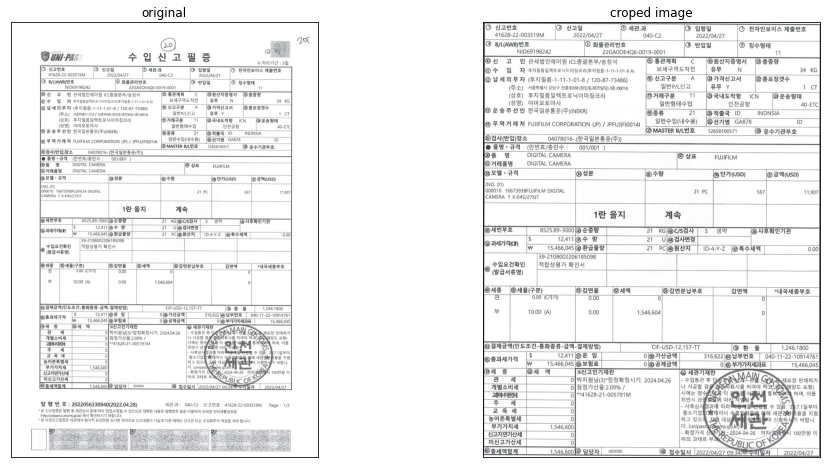

In [44]:
def crop_image(image_bgr):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    draw_image = image_bgr.copy()
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            x, y, w, h = cv2.boundingRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        crop_img = image_bgr
    else:
        # show the contour (outline) of the piece of paper
        # print ("Find rectangle contour",rot_rect)
        # print ("x, y, w, h ",x, y, w, h )
        # print ("screenCnt ",screenCnt )
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 2)
        crop_img = image_bgr[y:y + h, x:x + w]
        crop_success = True

    return crop_success, crop_img


flg, crop_image = crop_image(image)
# plt_imshow("문서외곽선인식", edge_detection(image))
if flg:
    plt_imshow(['original', 'croped image'], [image, crop_image])

# cv2.imwrite('../output/수출면장-PDF-img24-crop.jpg', crop_image)


In [45]:
data = pd.read_csv("../std-json/ORG_수입신고필증.csv")
data

,image,id,name,x,y,w,h
0,수입면장-PDF-img3-crop.jpg,1,신고번호,0,0,93,23
1,수입면장-PDF-img3-crop.jpg,2,수입자,0,51,199,17
2,수입면장-PDF-img3-crop.jpg,3,운송주선인,0,99,199,17
3,수입면장-PDF-img3-crop.jpg,4,무역거래처,0,115,199,17
4,수입면장-PDF-img3-crop.jpg,5,국내도착항,270,82,83,26
5,수입면장-PDF-img3-crop.jpg,6,적출국,269,104,142,15
6,수입면장-PDF-img3-crop.jpg,7,선기명,268,115,142,15
7,수입면장-PDF-img3-crop.jpg,8,품명,0,155,238,15
8,수입면장-PDF-img3-crop.jpg,9,거래품명,0,164,238,15
9,수입면장-PDF-img3-crop.jpg,10,세부번호,0,246,115,15


x, y, w, h :  0 0 93 23
x, y, w, h :  0 51 199 17
x, y, w, h :  0 99 199 17
x, y, w, h :  0 115 199 17
x, y, w, h :  270 82 83 26
x, y, w, h :  269 104 142 15
x, y, w, h :  268 115 142 15
x, y, w, h :  0 155 238 15
x, y, w, h :  0 164 238 15
x, y, w, h :  0 246 115 15
x, y, w, h :  217 269 90 15
x, y, w, h :  161 388 145 15


/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing

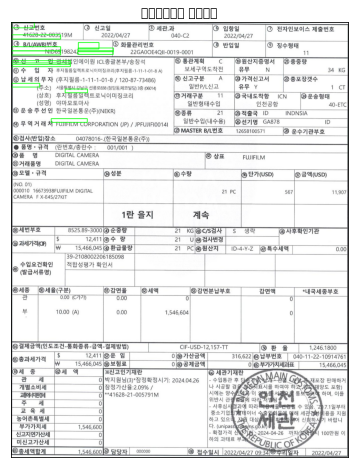

In [46]:
# x = xmin
# y = ymin
# w = xmax - xmin
# h = ymax - ymin

# cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),15)

for index, item in data.iterrows():
    # print(item['xMin'])
    x = int(item['x'])
    y = int(item["y"])
    w = int(item["w"])
    h = int(item["h"])
    print("x, y, w, h : ",x, y, w, h)
    draw_image = cv2.rectangle(crop_image, (x,y), (x+w,y+h), (0, 255, 0), 2)

plt_imshow("수입신고필증 추출항목", draw_image)

In [ ]:
# custom_config = r'-l kor+eng --psm 6'
custom_config = r'-l kor+eng --psm 4'
text = pytesseract.image_to_string(gray, config=custom_config)

In [ ]:
langs = ['ko', 'en']
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
results = reader.readtext(image)

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
simple_results = reader.readtext(image, detail = 0, paragraph=True)
simple_results

["점환 인 떼 미컴증 (yifi-P = 수 입 신 고 필 증 0G시집인 X 처리기간 3일 신고번호 신고입 세관 과 입합일 전자인보이스 제출번호 44025-22-030378M 2022/03/28 030 C3 2022/03/28 B/L(AWB)번호 화물관리번호 반입일 징수형태 YHBUSo1oz2 2ZCKCO02631-3024-00D1 11 신 고 인 이정과세법인 나병인 물관계회 @)원산지중명서 l 총중량 수 입 자 한국센트럴글래스(주)한국센트-1-12-1-01-6 A) 입히전신고 유무 N A,000 KG 납세의무 사 (인국신트-1-12-1-01-6 220-88-30353) 신고구분 0 가려신고서 콩노상셋수 (주소) 서율 강남구 역심동 태히란로116 동경빌딩요층 (06120) 일반서류신고 유무 Y 5 GT (상호) 한국센트럭글래스(주) @@ 거래구분 11 7) 국내도착항 KRPUS 운송형태 (성명) KAWAKAMI MAS 일반형태수입 부산함 10-FC 요송 주선 인 국보해운 주식회사 (KBEC) @종류 21 적손국 JP JAPAN 무역거래처 CENTRAL GLASs CO LTD (JP) JPCENTRAOUISN 일반수입내수용) 선기명 CONMAR MOON AG MASTER B/L버호 PCLUONY2D8OII 운수기관부호 @검사(반입)장소 03012240- (한국히지스터미널(주)부산컨테) 품명 . 규려 (관번회종관수 001/002 $품 명 CHEMICAL PREPARATIONS 상표 NO @거래압명 CHEMICAL PREPARATIONS '@모댁 . 규격 (@) 성분 수량 단가(USD) 금액(USD) (NO 01) PPROPYLENE GLYCOL PPK-HUZ 14DRUM(S) CAS NO.108-65-6 IMETHYLETHER ACETATE 2,880 KG 40,8 117,504 199,48%",
 '@@세번부호',
 '3824.29-3090| 순중량 117,655K)수 량 144,409,289 환급문량',
 '2,880 KG',
 "'디s검사 5   생락 검사변